In [1]:
import pandas as pd
import numpy as np
import cudf
import cupy as cp
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

In [2]:
return_2_yrs = pd.read_parquet('/mnt/share/Zidi/my_proj/return_minute.pqt')

# 数据预处理(因为我们想在收盘前购入，所以选择下午14:55之前的分钟频数据)
return_2_yrs = return_2_yrs[~return_2_yrs['time'].isin(['14:56','14:57','14:58', '14:59', '15:00'])]
return_2_yrs = return_2_yrs.dropna(how='any')
return_2_yrs['spread'] = return_2_yrs['high'] - return_2_yrs['low']

return_2_yrs = return_2_yrs.dropna()
return_2_yrs.head()

,code,date,time,open,high,low,close,volume,amount,spread
0,1,20220104,09:31,16.480000,16.500000,16.440001,16.459999,36924,60816580,0.059999
1,1,20220104,09:32,16.459999,16.459999,16.360001,16.370001,15569,25554244,0.099998
2,1,20220104,09:33,16.350000,16.360001,16.250000,16.270000,24743,40321696,0.110001
3,1,20220104,09:34,16.280001,16.309999,16.270000,16.309999,13607,22162056,0.039999
4,1,20220104,09:35,16.309999,16.350000,16.309999,16.350000,8237,13450944,0.040001


In [ ]:
spread_factor = return_2_yrs.groupby(['code', 'date'])['spread'].agg(['mean', 'std']).rename(columns={
    'mean': 'spread_mean',
    'std': 'spread_std'
})
spread_factor['micro_volatility'] = spread_factor['spread_mean'] / spread_factor['spread_std']

spread_factor = spread_factor.reset_index()

In [4]:
spread_factor

,code,date,spread_mean,spread_std,micro_volatility
0,1,20220104,0.018000,0.013486,1.334706
1,1,20220105,0.020298,0.016209,1.252242
2,1,20220106,0.021532,0.014971,1.438228
3,1,20220107,0.019106,0.012354,1.546602
4,1,20220110,0.024128,0.015261,1.581036
...,...,...,...,...,...
386842,689009,20231225,0.048894,0.035920,1.361195
386843,689009,20231226,0.081021,0.120060,0.674842
386844,689009,20231227,0.068468,0.062547,1.094659
386845,689009,20231228,0.064128,0.039402,1.627510


In [5]:
stock_return = pd.read_csv('stock_800.csv')
stock_return = stock_return.sort_values(by=['Symbol', 'Date'])
#把因子和收益率两张表合并在一起
spread_factor = spread_factor.merge(stock_return, left_on=['code','date'], right_on=['Symbol','Date']).drop(columns=['Date','Symbol'])
spread_factor = spread_factor.sort_values(by=['date','code'])

In [6]:
# 针对micro_volatility进行分组
spread_factor['rank'] = (
    spread_factor
    .groupby('date')['micro_volatility']
    .transform(lambda x: x.rank(method='first'))
)
spread_factor.head()

,code,date,spread_mean,spread_std,micro_volatility,open,high,low,close,pre_close,...,stock_800,return_inday,return_overnight,return_1min,return_5min,return_10min,return_30min,return_1hr,return_2hr,rank
0,1,20220104,0.018000,0.013486,1.334706,16.48,16.66,16.18,16.66,16.48,...,True,0.010922,-0.004802,-0.001214,-0.007888,-0.014563,-0.015777,-0.012743,-0.004248,276.0
484,2,20220104,0.039021,0.027431,1.422527,19.49,20.65,19.36,20.49,19.76,...,True,0.051308,-0.002928,-0.000513,-0.003079,0.000513,0.029759,0.038481,0.051821,359.0
968,9,20220104,0.026340,0.021548,1.222390,14.64,14.64,13.75,14.00,14.43,...,True,-0.043716,0.000000,-0.004098,-0.020492,-0.019809,-0.035519,-0.050546,-0.051913,198.0
1452,12,20220104,0.019958,0.015121,1.319896,9.90,10.19,9.82,9.90,9.93,...,True,0.000000,0.000000,0.003030,0.006061,0.024242,-0.001010,-0.004040,0.006061,266.0
1936,21,20220104,0.023361,0.018997,1.229760,15.80,16.29,15.79,16.13,15.84,...,True,0.020886,0.004340,0.006329,0.008228,0.006962,0.021519,0.017089,0.018354,207.0


In [7]:
spread_factor = spread_factor.dropna()

In [8]:
spread_factor = spread_factor.sort_values(by=['code','date'])
spread_factor['group'] = spread_factor.groupby(['date'])['rank'].transform(lambda x: (80*x.rank(method='first')/len(x)).astype('int'))
spread_factor

,code,date,spread_mean,spread_std,micro_volatility,open,high,low,close,pre_close,...,return_inday,return_overnight,return_1min,return_5min,return_10min,return_30min,return_1hr,return_2hr,rank,group
0,1,20220104,0.018000,0.013486,1.334706,16.48,16.66,16.18,16.66,16.48,...,0.010922,-0.004802,-0.001214,-0.007888,-0.014563,-0.015777,-0.012743,-0.004248,276.0,27
1,1,20220105,0.020298,0.016209,1.252242,16.58,17.22,16.55,17.15,16.66,...,0.034379,-0.002332,0.004825,0.014475,0.020507,0.029554,0.024729,0.033172,155.0,15
2,1,20220106,0.021532,0.014971,1.438228,17.11,17.27,17.00,17.12,17.15,...,0.000584,-0.001168,-0.002922,-0.005845,-0.004091,0.006429,-0.000584,-0.002338,364.0,36
3,1,20220107,0.019106,0.012354,1.546602,17.10,17.28,17.06,17.20,17.12,...,0.005848,0.005233,-0.000585,0.002339,0.004094,0.006433,0.001754,0.008772,425.0,42
4,1,20220110,0.024128,0.015261,1.581036,17.29,17.42,17.03,17.19,17.20,...,-0.005784,0.004072,-0.001157,0.006362,-0.004049,-0.009254,-0.011567,-0.008676,555.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386841,689009,20231222,0.056043,0.046133,1.214796,31.28,31.70,30.70,31.06,31.30,...,-0.007033,-0.006761,0.000959,-0.008632,-0.012468,-0.015985,-0.016944,-0.007033,89.0,8
386842,689009,20231225,0.048894,0.035920,1.361195,30.85,31.20,30.06,30.08,31.06,...,-0.024959,0.001995,0.002917,0.009724,0.009724,0.002593,0.003566,-0.014587,368.0,36
386843,689009,20231226,0.081021,0.120060,0.674842,30.14,30.25,26.00,27.85,30.08,...,-0.075979,0.001795,-0.002654,-0.031188,-0.035833,-0.081287,-0.089914,-0.065030,7.0,0
386844,689009,20231227,0.068468,0.062547,1.094659,27.90,28.89,27.18,28.89,27.85,...,0.035484,-0.010730,-0.002151,0.006093,0.000000,-0.008961,-0.001792,0.007168,70.0,7


In [9]:
portfolio_daily_return = (
    spread_factor
    .groupby(['date', 'group'])['return_overnight']
    .mean()
    .reset_index()
)

portfolio_daily_return = portfolio_daily_return.sort_values(by=['date'])

In [10]:
# 看看哪组的收益率表现最好
list1 = []
max_return = 0
max_group = 0
for i in range(1, 81):
    group_df = portfolio_daily_return[portfolio_daily_return['group']==i]
    group_df = group_df.sort_values(by=['date'])
    cum_ret = (1 + group_df['return_overnight']).cumprod()
    # 年化收益率
    if not cum_ret.empty:
        # print(cum_ret.iloc[-1])
        list1.append(cum_ret.iloc[-1])
        if cum_ret.iloc[-1] > max_return:
            max_return = cum_ret.iloc[-1]
            max_group = i
    else:
        print("该组为空，跳过")
    

print(max(list1),max_group)

1.2980205281235093 80


In [11]:
# 选取最大的组构建投资组合
group_df = portfolio_daily_return.groupby(['date'], as_index=False).agg({'group':'max'})
group_df = group_df.merge(portfolio_daily_return[['date','group','return_overnight']], on=['date','group'])

group_df = group_df.sort_values(by=['date'])
group_df['cum_return'] = (1 + group_df['return_overnight']).cumprod()
group_df = group_df.dropna()
group_df['date'] = pd.to_datetime(group_df['date'].astype('str'))

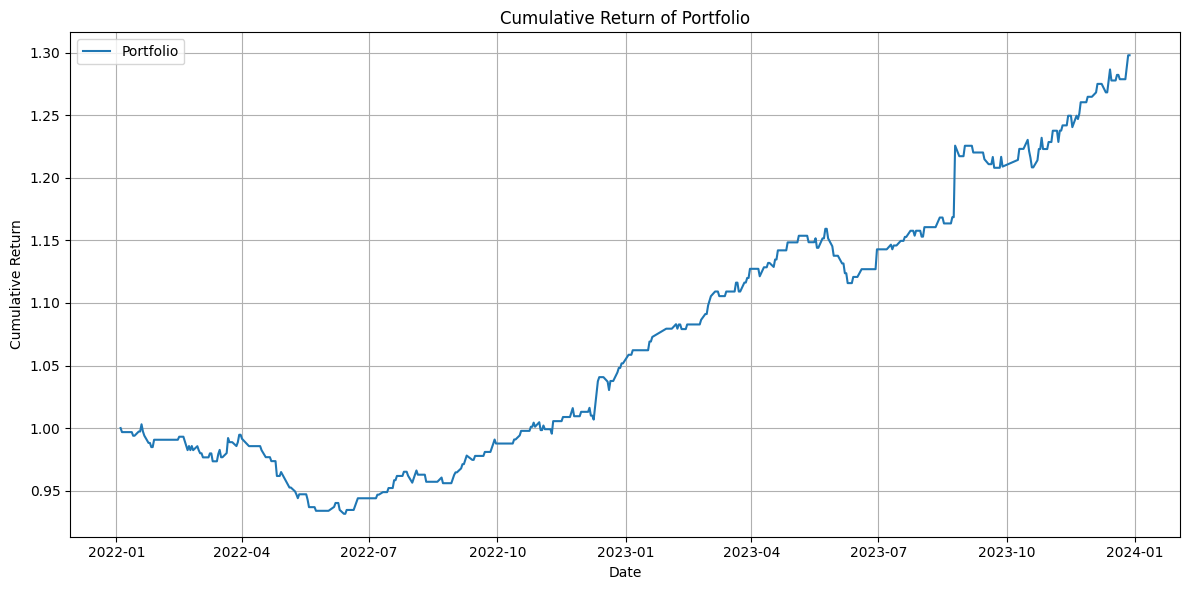

In [12]:
def plot_curve(df: cudf.DataFrame, horizontal_name: str, cum_return_name: str):
    plt.figure(figsize=(12, 6))
    plt.plot(df[horizontal_name], df[cum_return_name], label='Portfolio')
    plt.legend()
    plt.title("Cumulative Return of Portfolio")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return None
plot_curve(group_df, 'date', 'cum_return')

In [13]:
def cal_sharpe(df: cudf.DataFrame, rf: float, return_name: str) -> int:
    df['excess_return'] = df[return_name] - rf/252
    return (np.sqrt(252)*group_df['excess_return'].mean())/(group_df[return_name]).std()

cal_sharpe(group_df, 0.017, 'return_overnight')

1.8050539572240578